## Final Project - Marco Esposito
### Introduction

The provided data consist of four different csv files: Two *training* dataset files, one containing data about acceleration values of smartpones along the three axes at every time point and the other containing the class labels corresponding to four physical acivities (1 = standing, 2 = walking, 3 = stairs down, 4 = stairs up). Two *testing* dataset files, one containing a smaller amount of acceleration data and the other containing the empty class labels for each time point. Data was collected using the __[Beiwe research platform](https://github.com/onnela-lab/beiwe-backend)__. 

For this project, I'll attempt to classify the type of physical activity (i.e., class labels) by using a classification model. 
I'll use 3 different models for predicting categorical output, and with the help of a cross validation randomized search of best parameters I'll evaluate the performance of each model based on F1-score and accuracy metrics. By simply taking the mean of both scores, it'll give an indication on which model has the highest performance for this particular case.



(the labels in train_labels.csv are only provided for every 10th observation in train_time_series.csv)

### Importing libraries and Loading datasets

In [20]:
import pandas as pd
import numpy as np
from numpy import where
from collections import Counter
import time

from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from scipy.stats import loguniform, uniform
import scipy.stats

from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, cohen_kappa_score

import warnings
warnings.filterwarnings('ignore')

# get start time
t_start = time.perf_counter()
# import datasets
train_time = pd.read_csv('train_time_series.csv')
train_labels = pd.read_csv('train_labels.csv')
test_time = pd.read_csv('test_time_series.csv')
test_labels = pd.read_csv('test_labels.csv')



### Exploring and Cleaning Data

#### Train datasets:

In [21]:
display(train_labels, train_time)

,Unnamed: 0,timestamp,UTC time,label
0,20589,1565109931087,2019-08-06T16:45:31.087,1
1,20599,1565109932090,2019-08-06T16:45:32.090,1
2,20609,1565109933092,2019-08-06T16:45:33.092,1
3,20619,1565109934094,2019-08-06T16:45:34.094,1
4,20629,1565109935097,2019-08-06T16:45:35.097,1
...,...,...,...,...
370,24289,1565110302030,2019-08-06T16:51:42.030,4
371,24299,1565110303032,2019-08-06T16:51:43.032,4
372,24309,1565110304034,2019-08-06T16:51:44.034,4
373,24319,1565110305037,2019-08-06T16:51:45.037,4


,Unnamed: 0,timestamp,UTC time,accuracy,x,y,z
0,20586,1565109930787,2019-08-06T16:45:30.787,unknown,-0.006485,-0.934860,-0.069046
1,20587,1565109930887,2019-08-06T16:45:30.887,unknown,-0.066467,-1.015442,0.089554
2,20588,1565109930987,2019-08-06T16:45:30.987,unknown,-0.043488,-1.021255,0.178467
3,20589,1565109931087,2019-08-06T16:45:31.087,unknown,-0.053802,-0.987701,0.068985
4,20590,1565109931188,2019-08-06T16:45:31.188,unknown,-0.054031,-1.003616,0.126450
...,...,...,...,...,...,...,...
3739,24325,1565110305638,2019-08-06T16:51:45.638,unknown,0.024384,-0.710709,0.030304
3740,24326,1565110305738,2019-08-06T16:51:45.738,unknown,0.487228,-1.099136,-0.015213
3741,24327,1565110305838,2019-08-06T16:51:45.838,unknown,0.369446,-0.968506,0.036713
3742,24328,1565110305939,2019-08-06T16:51:45.939,unknown,0.167877,-0.802826,0.049805


#### Test datasets:

In [22]:
display(test_labels, test_time)

,Unnamed: 0,timestamp,UTC time,label
0,24339,1565110307041,2019-08-06T16:51:47.041,NaN
1,24349,1565110308043,2019-08-06T16:51:48.043,NaN
2,24359,1565110309046,2019-08-06T16:51:49.046,NaN
3,24369,1565110310048,2019-08-06T16:51:50.048,NaN
4,24379,1565110311050,2019-08-06T16:51:51.050,NaN
...,...,...,...,...
120,25539,1565110427366,2019-08-06T16:53:47.366,NaN
121,25549,1565110428369,2019-08-06T16:53:48.369,NaN
122,25559,1565110429371,2019-08-06T16:53:49.371,NaN
123,25569,1565110430373,2019-08-06T16:53:50.373,NaN


,Unnamed: 0,timestamp,UTC time,accuracy,x,y,z
0,24330,1565110306139,2019-08-06T16:51:46.139,unknown,0.034286,-1.504456,0.157623
1,24331,1565110306239,2019-08-06T16:51:46.239,unknown,0.409164,-1.038544,0.030975
2,24332,1565110306340,2019-08-06T16:51:46.340,unknown,-0.234390,-0.984558,0.124771
3,24333,1565110306440,2019-08-06T16:51:46.440,unknown,0.251114,-0.787003,0.054810
4,24334,1565110306540,2019-08-06T16:51:46.540,unknown,0.109924,-0.169510,0.235550
...,...,...,...,...,...,...,...
1245,25575,1565110430975,2019-08-06T16:53:50.975,unknown,0.036499,-0.724823,0.553802
1246,25576,1565110431075,2019-08-06T16:53:51.075,unknown,-0.159241,0.307022,0.142410
1247,25577,1565110431175,2019-08-06T16:53:51.175,unknown,-0.037964,-0.673706,1.065445
1248,25578,1565110431275,2019-08-06T16:53:51.275,unknown,0.255707,-1.485397,-0.013336


#### Check if there are any missing values

In [23]:
print("Train time series missing values: \n", train_time.isna().sum())
print("Test time series missing values: \n", test_time.isna().sum())
print("Train labels missing values: \n", train_labels.isna().sum())

Train time series missing values: 
 Unnamed: 0    0
timestamp     0
UTC time      0
accuracy      0
x             0
y             0
z             0
dtype: int64
Test time series missing values: 
 Unnamed: 0    0
timestamp     0
UTC time      0
accuracy      0
x             0
y             0
z             0
dtype: int64
Train labels missing values: 
 Unnamed: 0    0
timestamp     0
UTC time      0
label         0
dtype: int64


#### Check most common class

Class labels count:
 2    213
3     88
4     47
1     27
Name: label, dtype: int64


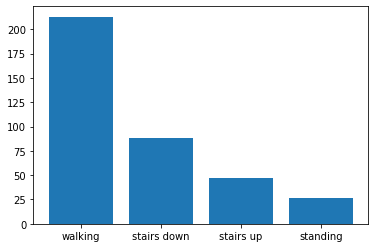

In [24]:
# Check most common class
print("Class labels count:\n", train_labels['label'].value_counts())
# Name class labels for later plotting 
one = 'standing'
two = 'walking'
three = 'stairs down'
four = 'stairs up'
plt.bar([1,2,3,4], train_labels['label'].value_counts(), tick_label=[two, three, four, one]);


From the above count the dataset presents itself as strongly **imbalanced**.
Since collecting more data is not an option here, I'll make use of oversampling to mitigate this issue. 


#### Define input and output variables

Since labels in train_labels.csv are provided for every 10th observation, indeces of timestamps associated with labels in both train and test set need to be extracted.

In [25]:
# 1st get corresponding indeces of timestamps
idx_train = np.isin( train_time['timestamp'], train_labels['timestamp']) 
idx_test = np.isin( test_time['timestamp'], test_labels['timestamp']) 

# 2nd define inputs and outputs for our models.
# We're only interested in the last 3 cols for the input matrix (i.e., accelerations x,y,z)
X_train = train_time[idx_train].iloc[:, -3:]
X_test = test_time[idx_test].iloc[:, -3:]
y_train = train_labels['label']
# Do the numbers check out? 
print("Now the outcome y has the same number of observation as the predictors X: \n", len(y_train) == len(X_train))

Now the outcome y has the same number of observation as the predictors X: 
 True


In [26]:
train_mean = X_train.mean()
train_std = X_train.std()

X_train = (X_train - train_mean) / train_std
X_test = (X_test - train_mean) / train_std

### Visualize the data

Check distributions and correlations of input data

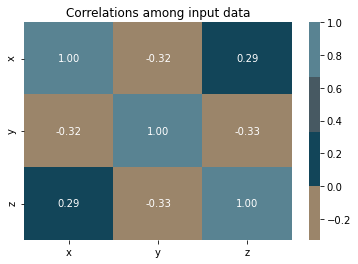

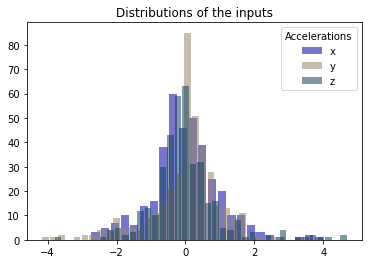

In [27]:
cmap = colors.ListedColormap(['#9B856A', '#124559', '#475962', '#598392'])
ax = plt.axes()
sns.heatmap(X_train.corr(), annot=True, fmt='.2f', cmap=cmap, ax = ax)
ax.set_title('Correlations among input data')

plt.figure()
plt.hist(X_train.iloc[:,0], bins='auto', color='#0504aa',
                            alpha=0.55, rwidth=0.85, label='x');

plt.hist(X_train.iloc[:,1], bins='auto', color='#9B856A',
                            alpha=0.55, rwidth=0.85, label='y');
plt.hist(X_train.iloc[:,2], bins='auto', color='#124559',
                            alpha=0.55, rwidth=0.85, label='z');
plt.legend(loc='upper right', title = 'Accelerations');
plt.title('Distributions of the inputs');


Check distribution of inputs as a function of class labels

Switch to %matplotlib qt if you want to interact and rotate the 3D plot


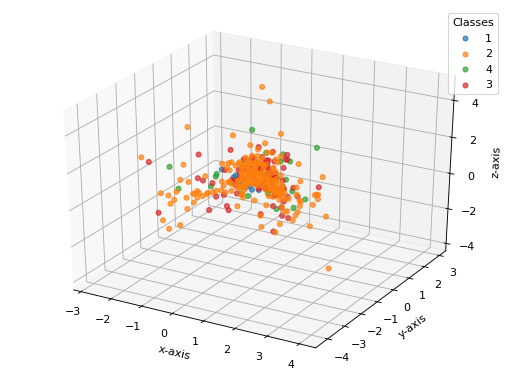

In [28]:
print( 'Switch to %matplotlib qt if you want to interact and rotate the 3D plot')
#%matplotlib qt
%matplotlib inline
counter = Counter(y_train)
fig = plt.figure(figsize=(8, 6), dpi=80)
ax = fig.add_subplot(projection='3d')
for label, _ in counter.items():
	row_ix = where(y_train == label)[0]
	ax.scatter(X_train.iloc[row_ix, 0], X_train.iloc[row_ix, 1], X_train.iloc[row_ix, 2], alpha=0.7,label=str(label),marker='o', s=20)
plt.legend(loc='upper right', title = 'Classes')
ax.set_xlabel('x-axis')
ax.set_ylabel('y-axis')
ax.set_zlabel('z-axis');

Also from the above scatter plot one can get a sense of the strong imbalance and overlapping of data.

### Modeling

#### Model selection
For this project I'll focus on the three classification models that were covered in the course: *multinomial logistic regression*, *random forest classifier* and *nearest neighbors classifier*. To structure each of these models, a randomized grid search of respective hyperparameters will be used. In a randomized search, a statistical distribution for each hyperparameter is provided from which values may be randomly sampled.
(The range of values for tuning the random forest classifier were taken from __[this blog post](https://towardsdatascience.com/a-practical-guide-to-implementing-a-random-forest-classifier-in-python-979988d8a263)__).  

#### Define the range of possible values for all hyperparameters:

In [29]:
hyper_param = [{},{},{}]

## Search space for Logistic Regression
hyper_param[0]['solver'] = ['lbfgs', 'liblinear']
hyper_param[0]['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
hyper_param[0]['C'] = loguniform(1e0, 1e3)

## Search space for Random Forest Classifier
hyper_param[1] = {'n_estimators': np.linspace(100, 3000, int((3000-100)/200) + 1, dtype=int),  # Number of trees in random forest
'max_features': ['auto', 'sqrt'],  # Number of features to consider at every split
'max_depth': [1, 5, 10, 20, 50, 75, 100, 150, 200],  # Maximum number of levels in tree
'min_samples_split': [1, 2, 5, 10, 15, 20, 30],  # Minimum number of samples required to split a node
'min_samples_leaf': [1, 2, 3, 4],  # Minimum number of samples required at each leaf node
'bootstrap': [True, False],
'criterion': ['gini', 'entropy']}

## Search space for Nearest Neighbors Classifier
hyper_param[2] = {'leaf_size': list(range(1,50)), 'n_neighbors': list(range(1,30)), 'p': [1,2]}

#### Loop through the hyperparameters space and corresponding models:
After each model is tuned with the best hyperparameters, it will be fitted to the training set and scoring results will be stored in lists.
A stratified K-Fold cross validation will be used to account for the large imbalance of class labels (each fold will have approximately the same percentage of samples of each class label). 

In [30]:
models = [LogisticRegression(multi_class='multinomial'), RandomForestClassifier(), KNeighborsClassifier()]

# Initialize empty lists for storing results
accuracies = []
pred_classes = []
f1score = []
kappascore = []
conf_mtx = []
bestparameters = []
skf = StratifiedKFold(n_splits=4)

for m, s in zip(models, hyper_param):
    
    clf = RandomizedSearchCV(m, s, n_iter=10, scoring='accuracy', n_jobs=4, cv=skf, verbose=2, random_state=42)
    clf.fit(X_train, y_train)
    bestparameters.append( clf.best_params_ )
    
    accuracies.append( clf.score(X_train, y_train) )
    kappascore.append( cohen_kappa_score(y_train, clf.predict(X_train)))
    pred_classes.append( clf.predict(X_train) )
    f1score.append( f1_score(y_train, clf.predict(X_train), average="weighted")) 
    conf_mtx.append( confusion_matrix(y_train, clf.predict(X_train),  labels = [1, 2, 3, 4]) )

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits


**Confusion matrices of models performance**

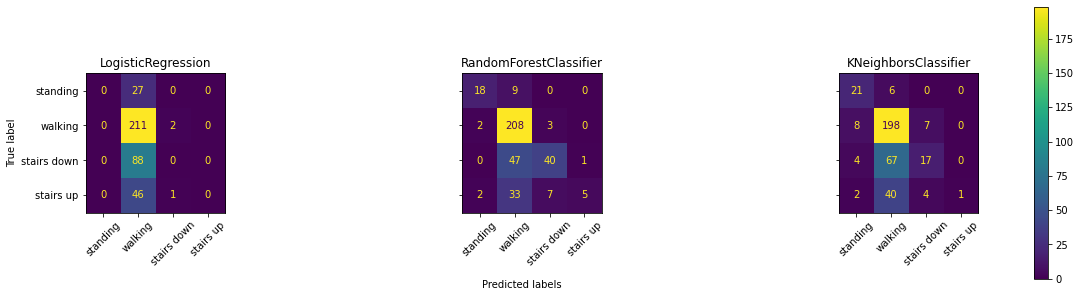

In [31]:
m_names = ['LogisticRegression', 'RandomForestClassifier', 'KNeighborsClassifier']

f, axes = plt.subplots(1, 3, figsize=(20, 5), sharey='row')
for n, i in enumerate(m_names):
    disp = ConfusionMatrixDisplay(conf_mtx[n], display_labels=[one, two, three, four])
    disp.plot(ax=axes[n], xticks_rotation=45)
    disp.ax_.set_title(i)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if n!=0:
        disp.ax_.set_ylabel('')
               
f.text(0.4, 0.1, 'Predicted labels', ha='left')
plt.subplots_adjust(wspace=1.7, hspace=0.1)        
f.colorbar(disp.im_, ax=axes)
plt.show()
        

Since accuracy alone is not optimal to evaluate imbalanced datasets (i.e., accuracy paradox), **model selection will be based on the average between Accuracy and F1-scores**. Furthermore, the highest Cohen's kappa score, a value between -1 and 1, will be assessed to further confirm the best model (kappa score represents accuracy normalized by the imbalance of the classes in the data).

In [32]:
# Store in df model selection results
results = pd.DataFrame({'Model': m_names, 'Accuracy': accuracies,'F1-scores':f1score, 
                        'Average Acc-F1':np.mean([f1score,accuracies],axis=0),'Kappa-scores':kappascore})
results

,Model,Accuracy,F1-scores,Average Acc-F1,Kappa-scores
0,LogisticRegression,0.562667,0.409737,0.486202,-0.006135
1,RandomForestClassifier,0.722667,0.675894,0.699280,0.458995
2,KNeighborsClassifier,0.632000,0.552030,0.592015,0.270366


The above metrics point to the Random Forest Classifier as the best model in our case.
However, from the confusion matrix and the Cohen's kappa score it is clear that the there is still not a good agreement in the data, hence model performance is still impaired by the class label imbalance.

### SMOTE for Balancing Data

Now that the best model using randomized search was selected, I'll try to see if a resampled dataset deliver better results. Given the small size of the train set, data was augmented (i.e., oversampled) for the minority classes.
__[SMOTE algorithm](https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/)__ works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

**Generate new samples**

In [33]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE()
X, y = oversample.fit_resample(X_train, y_train)
print('Data before SMOTE: ', Counter(y_train) )
print('Data after SMOTE: ', Counter(y) )

Data before SMOTE:  Counter({2: 213, 3: 88, 4: 47, 1: 27})
Data after SMOTE:  Counter({1: 213, 2: 213, 4: 213, 3: 213})


**Fit classifier to the newly generated train set**

In [34]:
p = bestparameters[1] # Use best parameters as previously selected
model = RandomForestClassifier(**p) # unpack the dict of parameters into the classifier
model.fit(X, y)

results2 = pd.DataFrame({'Accuracy': [accuracies[1], model.score(X, y)],
                      'F1-scores':[f1score[1], f1_score(y, model.predict(X), average="weighted")],
                        'Kappa-scores':[ kappascore[1], cohen_kappa_score(y, model.predict(X))] })
results2.index = ['Imbalanced data', 'SMOTE data']
results2


,Accuracy,F1-scores,Kappa-scores
Imbalanced data,0.722667,0.675894,0.458995
SMOTE data,0.850939,0.848939,0.801252


### Predict labels and store results
Now predicted labels will be generated for the *test dataset*.

In [35]:
output = model.predict(X_test)
# get end time 
t_end = time.perf_counter()
t_diff = t_end - t_start
print(t_diff)

test_labels['label'] = output
test_labels


61.75527486199985


,Unnamed: 0,timestamp,UTC time,label
0,24339,1565110307041,2019-08-06T16:51:47.041,3
1,24349,1565110308043,2019-08-06T16:51:48.043,4
2,24359,1565110309046,2019-08-06T16:51:49.046,4
3,24369,1565110310048,2019-08-06T16:51:50.048,3
4,24379,1565110311050,2019-08-06T16:51:51.050,2
...,...,...,...,...
120,25539,1565110427366,2019-08-06T16:53:47.366,2
121,25549,1565110428369,2019-08-06T16:53:48.369,2
122,25559,1565110429371,2019-08-06T16:53:49.371,4
123,25569,1565110430373,2019-08-06T16:53:50.373,2


In [36]:
test_labels.to_csv('test_predicted_labels.csv')